In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


Text(0.5, 1.0, '尤度関数')

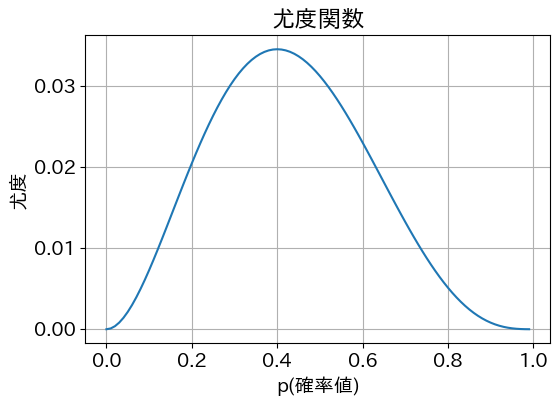

In [3]:
# 尤度関数 lh(p) を定義
# ------------------------------------------------------------
# ここでの lh(p) は、確率パラメータ p に対する「尤度 (likelihood)」を表している。
#
# 例えば、「当たり = 1, ハズレ = 0」とするベルヌーイ試行を 5 回行い、
#   観測データが「成功 2 回・失敗 3 回」であった状況を考える。
#
# このとき、p を「1 回の試行で成功する確率」とすると、二項分布に基づく尤度は
#
#   L(p)
#     = P(X = 2 | p)
#     = C(5, 2) p^2 (1-p)^3
#
# となる。ここで C(5,2) は二項係数（組合せの数）で、p に依存しない定数である。
#
# ベイズ推論では、事後分布 p(p | データ) を求める際に
#
#   p(p | データ) ∝ L(p) * 事前分布(p)
#
# という比例関係を使うが、「p に依存しない定数」は事後分布を正規化する際に
# 吸収されるため、解析・可視化の目的では
#
#   L(p) ∝ p^2 (1-p)^3
#
# の部分だけを見れば十分である。
#
# この関数 lh(p) は、まさにこの「定数因子を省いた尤度」に対応している。
def lh(p):
    return p**2 * (1 - p) ** 3


# グラフ描画用 p 座標の定義
# ------------------------------------------------------------
# ベルヌーイ試行における成功確率 p は 0 < p < 1 の範囲をとるので、
# ここでは 0.0 以上 1.0 未満の範囲を 0.01 刻みで離散化している。
#
#   p = 0.00, 0.01, 0.02, ..., 0.99
#
# の各点で lh(p) を評価し、その形状（どの p がもっとも尤もらしいか）を可視化する。
p = np.arange(0.0, 1.0, 0.01)

# グラフ描画
plt.rcParams["figure.figsize"] = (6, 4)

# lh(p) = p^2 (1-p)^3 のグラフを描画
# ------------------------------------------------------------
# 理論的には、この関数の最大値を与える p は
#
#   L(p) ∝ p^2 (1-p)^3
#
# の対数をとって微分することで求められる。
#
#   log L(p) = 2 log p + 3 log(1-p) + const
#
# これを p で微分すると
#
#   d/dp log L(p)
#     = 2/p - 3/(1-p)
#
# なので、0 になる条件は
#
#   2/p - 3/(1-p) = 0
#   ⇔ 2(1-p) = 3p
#   ⇔ 2 = 5p
#   ⇔ p = 2/5 = 0.4
#
# となる。したがって lh(p) の山の頂上は p = 0.4 にあり、
# 「成功 2 回・失敗 3 回」という観測データのもとで最尤推定値（MLE）は p̂ = 2/5 である。
#
# このグラフを描くことで、
#   - p が 0 や 1 に近いと尤度が 0 に近づく（観測データと矛盾する）
#   - p ≈ 0.4 の近くで尤度が最大になる
# という二項尤度の典型的な形を視覚的に確認できる。
plt.plot(p, lh(p))

# x 軸ラベル
# p は「1 回の試行で成功する確率（0〜1 の実数）」を表す。
plt.xlabel("p(確率値)")

# y 軸ラベル
# y 軸は「尤度 L(p)」を表しており、「与えられた p のもとで観測データがどれくらい起こりやすいか」
# を数値化したものになっている。
plt.ylabel("尤度")

# タイトル設定
# 「尤度関数」と明示することで、このグラフが「p の関数としての L(p)」であり、
# 確率密度関数 f(p) ではない（積分して 1 になる必要はない）ことを意識させる狙いがある。
#
# ベイズ推論では、この尤度関数に事前分布を掛けて正規化することで事後分布を構成するため、
# 尤度の形状を理解しておくことは非常に重要である。
plt.title("尤度関数")

In [4]:
import torch  # PyTorch ライブラリのインポート（自動微分とテンソル演算を使う）


def log_lh(p):  # 対数尤度（log-likelihood）を返す関数
    """
    log 尤度: log L(p) = 2 log p + 3 log(1-p)
    ---------------------------------------------------
    元の尤度関数が

        L(p) = p^2 (1-p)^3

    であったので、その対数をとると

        log L(p) = 2 log p + 3 log(1-p)

    となる。対数をとることで

        - 積が和に変わる（数値的に安定で扱いやすい）
        - 最尤推定では L(p) を最大化する代わりに log L(p) を最大化しても良い
          （単調変換のため）

    という利点がある。
    """
    return 2 * torch.log(p) + 3 * torch.log(1 - p)


# 繰り返し回数（エポック数）
# ---------------------------------------------------
# 勾配法でパラメータ p を更新していく回数。
# num_epochs が多すぎると収束後も更新が続いて p が(0,1)の範囲外に
# 飛び出す可能性がある一方で、少なすぎると最尤値に十分近づかないことがある。
num_epochs = 40

# 学習率 (learning rate)
# ---------------------------------------------------
# 勾配法でパラメータを更新するときのステップ幅。
# 大きすぎると発散する・振動するリスクがあり、小さすぎると収束が遅い。
lr = 0.01

# パラメータ初期値 (p=0.1)
# ---------------------------------------------------
# p は「1 回のベルヌーイ試行で成功する確率」を表す連続パラメータ。
# ここでは初期値として p = 0.1 を与えている。
#
# dtype=torch.float32: 32bit 浮動小数点
# requires_grad=True: このテンソルについて損失からの勾配を自動で計算する
#
# 理論的には、対数尤度
#
#   log L(p) = 2 log p + 3 log(1-p)
#
# を p で微分すると
#
#   d/dp log L(p) = 2/p - 3/(1-p)
#
# これを 0 とおくと
#
#   2/p - 3/(1-p) = 0
#   ⇒ 2(1-p) = 3p
#   ⇒ 2 = 5p
#   ⇒ p* = 2/5 = 0.4
#
# が最尤推定値（MLE）となる。
# このコードは、勾配降下法で「p をだんだん 0.4 に近づけていく」挙動を数値的に確認している。
p = torch.tensor(0.1, dtype=torch.float32, requires_grad=True)

# 学習のログを保存する配列
# ---------------------------------------------------
# logs の各行は [epoch, p の値, loss の値] を格納する想定。
# 後から収束の様子をプロットするなどの用途に使える。
logs = np.zeros((0, 3))

# 勾配法によるパラメータ更新ループ
for epoch in range(num_epochs):
    # 損失計算
    # ---------------------------------------------------
    # ここでは「対数尤度を最大化したい」ので、
    #
    #   maximize log_lh(p)
    #
    # と同値な問題
    #
    #   minimize -log_lh(p)
    #
    # を解くために、損失関数 (loss) として
    #
    #   loss(p) = - log_lh(p)
    #
    # を採用している。
    #
    # 勾配降下法は「損失を最小化する」アルゴリズムなので、
    # log 尤度最大化問題を損失最小化問題に変換していることに注意。
    loss = -log_lh(p)

    # 勾配計算
    # ---------------------------------------------------
    # loss.backward() により、backpropagation を実行し、
    # p.grad に ∂loss/∂p が自動的に格納される。
    #
    # 理論的には、
    #
    #   loss(p) = -[2 log p + 3 log(1-p)]
    #
    # より、
    #
    #   d(loss)/dp = -(2/p - 3/(1-p)) = -2/p + 3/(1-p)
    #
    # となる。これを用いて
    #
    #   p ← p - lr * d(loss)/dp
    #
    # と更新することは、
    #   log_lh(p) の勾配上昇 (gradient ascent)
    # を行うことと等価である。
    loss.backward()

    # パラメータ更新（勾配降下ステップ）
    with torch.no_grad():
        # p = p - lr * grad
        # ---------------------------------------------------
        # p.grad には現在の p における ∂loss/∂p が入っているので、
        # 勾配降下法の更新式
        #
        #   p_{t+1} = p_t - η ∂loss/∂p_t
        #
        # をそのまま実装している。
        #
        # ここで η = lr（learning rate）。
        p -= lr * p.grad

        # 勾配値の初期化
        # ---------------------------------------------------
        # PyTorch の Autograd は勾配を「加算」していく仕様のため、
        # 各ステップの終了時に grad をゼロクリアしておかないと
        # 勾配がステップを跨いで蓄積してしまう。
        p.grad.zero_()

    # ログの記録
    # ---------------------------------------------------
    # epoch: 今何ステップ目か
    # p.item(): 現在の p のスカラー値
    # loss.item(): 現在の損失値（= -log 尤度）
    #
    # MLE の理論値 p* = 0.4 に向かって p が収束していき、
    # それに伴って loss が減少していく様子を、後から可視化できるように記録している。
    log = np.array([epoch, p.item(), loss.item()]).reshape(1, -1)
    logs = np.vstack([logs, log])

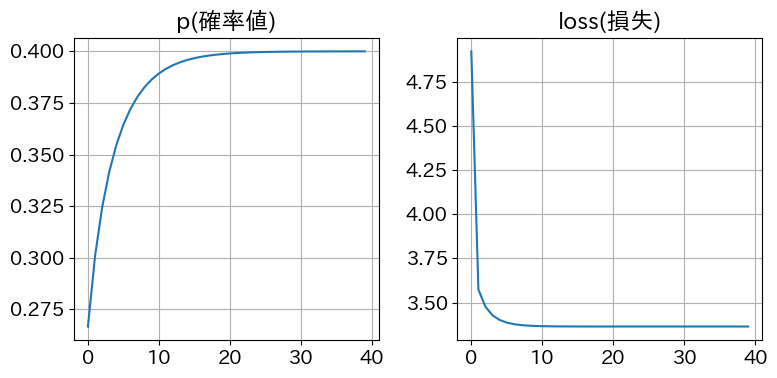

In [5]:
plt.rcParams["figure.figsize"] = (8, 4)
fig, axes = plt.subplots(1, 2)
axes[0].plot(logs[:, 0], logs[:, 1])
axes[0].set_title("p(確率値)")
axes[1].plot(logs[:, 0], logs[:, 2])
axes[1].set_title("loss(損失)")
plt.tight_layout()

In [6]:
X = np.array([1, 0, 0, 1, 0])
print(X)

[1 0 0 1 0]


In [7]:
# コンテキスト定義
# ------------------------------------------------------------
# PyMC では pm.Model() が「確率モデル（グラフィカルモデル）」のコンテナに相当する。
# model1 というインスタンスを作成しておき、with 文の中で定義される確率変数を
# このモデルに紐づけていく。
#
# 理論的には、ここで構築しようとしているのは
#
#   1. パラメータ p（成功確率）に対する事前分布
#   2. 観測データ X に対する尤度
#
# からなるベイズモデルであり、ベイズの定理
#
#   p(p | X) ∝ p(X | p) p(p)
#
# に従って「事後分布 p(p | X)」を計算するための枠組みに相当する。
model1 = pm.Model()

with model1:
    # pm.Uniform: 一様分布による事前分布
    # --------------------------------------------------------
    # p はベルヌーイ試行の「成功確率」を表すパラメータ（0〜1 の連続値）。
    #
    #   p ~ Uniform(0, 1)
    #
    # と置くことで、「0〜1 のどの値も同じだけあり得る」という非情報的（フラット）な
    # 事前分布を仮定している。これは連続一様分布であり、ベータ分布で書けば
    #
    #   p ~ Beta(1, 1)
    #
    # と同値である。
    #
    # ベイズ的には、この p が「データを観測する前の成功確率に関する信念」を表し、
    # 後で尤度 p(X | p) と組み合わせることで事後分布 p(p | X) に更新される。
    p = pm.Uniform("p", lower=0.0, upper=1.0)

    # pm.Bernoulli: ベルヌーイ分布による尤度（観測モデル）
    # --------------------------------------------------------
    # X_obs は観測された 0/1 データ（成功=1, 失敗=0）を表す。
    # PyMC では `observed=X` の形で実データを渡すことで、
    #
    #   X_obs | p ~ Bernoulli(p)
    #
    # という尤度モデル
    #
    #   p(X | p) = ∏ Bernoulli(X_i | p)
    #
    # を定義していると解釈できる（X がベクトルの場合は、独立同分布 i.i.d. を暗黙に仮定）。
    #
    # ここでの理論的な構造は
    #
    #   事前分布:  p ~ Uniform(0,1) = Beta(1,1)
    #   尤度    :  X_i | p ~ Bernoulli(p),  i=1,...,n
    #
    # という「ベータ–ベルヌーイ共役モデル」になっている。
    # 観測データ X の成功回数を s = Σ X_i、失敗回数を f = n - s とすると、
    # ベイズの定理と共役性により事後分布は解析的に
    #
    #   p | X ~ Beta(1 + s, 1 + f)
    #
    # となる。この事後分布は「データを見たあとの成功確率に対する不確実性」を
    # 完全な分布の形で表現している。
    #
    # PyMC の立場から見ると、この 2 行で
    #
    #   p(p, X) = p(X | p) p(p)
    #
    # という同時分布の構造が定義されており、後続の `pm.sample()` などで
    # p(p | X) に対応するサンプル（事後サンプル）を生成できるようになる。
    X_obs = pm.Bernoulli("X_obs", p=p, observed=X)

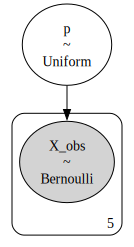

In [8]:
# モデル構造の可視化用オブジェクトを作成
# ------------------------------------------------------------
# pm.model_to_graphviz(model1) は、PyMC で定義した model1 の
# 「グラフィカルモデル（有向グラフ）」を Graphviz 形式で生成する関数である。
#
# 理論的には、先ほど定義したモデル
#
#   p ~ Uniform(0,1)
#   X_obs | p ~ Bernoulli(p)
#
# は、ベイズネット（有向グラフ）として
#
#        p  ───▶  X_obs
#
# のように表現できる。
#
# - ノード p      : 潜在変数（成功確率パラメータ）
# - ノード X_obs : 観測変数（0/1データ）
#
# 矢印 p → X_obs は「p が与えられたときに X_obs が生成される」という
# 条件付き確率構造 p(X_obs | p) を表している。
#
# model_to_graphviz は、この「確率変数の依存関係」を Graphviz の有向グラフ
# として可視化するための便利関数であり、ベイズモデルの構造を視覚的に確認
# する際に非常に有用である。
g = pm.model_to_graphviz(model1)

# グラフの表示
# ------------------------------------------------------------
# display(g) によって、Jupyter/Notebook 上に Graphviz でレンダリングされた
# グラフィカルモデルが描画される。
#
# ここで見えている図は、単なる「お絵描き」ではなく、
#   - どの変数がパラメータ（潜在変数）なのか
#   - どの変数が観測データなのか
#   - どの変数がどの変数に依存しているのか
# を表す「確率モデルの構造（因果・生成の向き）」そのものである。
#
# 特にベイズモデリングでは、複雑な階層モデルや多変量モデルになると、
# 数式だけでは依存関係が直感的に把握しづらくなるため、このような
# グラフィカルな表現でモデル構造を確認することが、理論理解とデバッグの両面で重要になる。
display(g)

In [10]:
# ベイズ推論による事後分布サンプリング
# ------------------------------------------------------------
# ここまでで model1 として定義されているのは
#
#   p ~ Uniform(0,1)
#   X_obs | p ~ Bernoulli(p)
#
# というベータ–ベルヌーイ型（今回は事前が一様）のベイズモデルである。
# このモデルに対して「事後分布 p(p | X_obs) からのサンプル」を
# MCMC（マルコフ連鎖モンテカルロ）で生成するのが pm.sample の役割になる。
#
# 理論的には、ベイズの定理により事後分布は
#
#   p(p | X_obs) ∝ p(X_obs | p) p(p)
#
# で与えられるが、一般にはこの右辺を解析的に正規化できないため、
# 直接の計算ではなく「サンプルを生成して分布を近似する」手法（MCMC）が用いられる。
#
# PyMC の pm.sample(...) は、デフォルトでは NUTS (No-U-Turn Sampler) という
# Hamiltonian Monte Carlo(HMC) 系のアルゴリズムを使って、
# この事後分布からのサンプル列（マルコフ連鎖）を生成してくれる。
#
# ここで得られる idata1_1 は、ArviZ 互換の InferenceData であり、
#   - 事後サンプル（posterior）
#   - チューニング情報
#   - ログ尤度など（オプション）
# を含む解析用コンテナとして使える。

with model1:
    idata1_1 = pm.sample(
        # chains: 独立に走らせるマルコフ連鎖の本数（デフォルト 2）。
        # --------------------------------------------------------
        # ベイズ推論では、単一の鎖だけを見て「収束した」と判断するのは危険である。
        # 複数の鎖（ここでは 3 本）を別々の初期値から走らせ、
        #
        #   - 各鎖が同じ分布に収束しているか
        #   - 鎖どうしのばらつきが小さいか（R-hat など）
        #
        # をチェックすることで、事後分布への混合・収束を診断できる。
        chains=3,
        # tune: チューニング（ウォームアップ）ステップ数（デフォルト 1000）。
        # --------------------------------------------------------
        # NUTS/HMC では、ステップサイズや質量行列といったパラメータを
        # 「サンプルを取りながら自動調整」するフェーズが必要になる。
        #
        #   - tune ステップ中: サンプラーのパラメータを学習・調整する
        #   - その間に生成されたサンプルは「事後分布からの代表サンプル」
        #     と見なさないため、最終的な解析からは除外される
        #
        # という扱いになる。
        # ここでは 2000 ステップをチューニングに割り当てており、
        # 比較的余裕を持たせた設定と言える。
        tune=2000,
        # draws: チューニング後に保持するサンプル数（デフォルト 1000）。
        # --------------------------------------------------------
        # tune ステップ終了後に、事後分布からのサンプルとして保存するステップ数。
        # ここでは 1 鎖あたり 2000 サンプルを保持する設定になっている。
        #
        # 総サンプル数としては「chains × draws」になるので、
        #   3 本 × 2000 = 6000 サンプル
        # の事後サンプルが得られることになる（ただし解析の際は
        # thinning や burn-in の扱いをどうするかも検討の余地がある）。
        #
        # 理論的には、サンプルサイズ N を増やすと
        #
        #   - 事後分布に基づく期待値・分散・HDI などの推定精度が向上する
        #   - ただし計算コストも線形に増える
        #
        # というトレードオフがあり、この設定値はそのバランスを取るパラメータである。
        draws=2000,
        # random_seed: 乱数シード
        # --------------------------------------------------------
        # MCMC は確率的アルゴリズムなので、乱数シードが異なると
        # サンプル列も微妙に異なる。
        # random_seed=42 を固定することで、
        #
        #   - 同じコードを再実行したときに、ほぼ同じ結果を再現できる
        #   - 実験結果（図や統計量）を論文・レポートとして残す際に再現性を確保できる
        #
        # という実務上重要な性質を得ている。
        random_seed=42,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [p]


Output()

Sampling 3 chains for 2_000 tune and 2_000 draw iterations (6_000 + 6_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [12]:
with model1:
    # 事後分布サンプリング（簡易設定版）
    # --------------------------------------------------------
    # すでに同じ model1 に対して、明示的に
    #
    #   chains=3, tune=2000, draws=2000
    #
    # と指定したサンプリングを行っているが、ここではあえて
    # デフォルト設定に近い形で pm.sample を呼び出している。
    #
    # pm.sample(...) は、モデルにより定義される事後分布
    #
    #   p(p | X_obs) ∝ p(X_obs | p) p(p)
    #
    # からのサンプル列を MCMC（標準では NUTS）で生成する関数であり、
    # この行で行っていることの理論的内容は、先の idata1_1 のときと同じく
    #
    #   「ベイズの定理で定義される事後分布を、サンプルとして近似する」
    #
    # という操作である。
    #
    # 引数を省略した場合、主に以下のようなデフォルトが使われる（PyMC のバージョンによる差はあるが概ねのイメージ）:
    #
    #   - chains: 4 本程度
    #   - tune  : 1000 ステップ程度（ウォームアップ）
    #   - draws : 1000 ステップ程度（保持するサンプル）
    #
    # したがって、
    #   - idata1_1: パラメータを細かく指定した「本気の」サンプリング設定
    #   - idata1_2: デフォルトに任せた「簡易な」サンプリング設定
    # という位置づけになっている。
    #
    # ベイズ推論の観点からは、デフォルト設定で得られるサンプルでも
    # 「事後の形」や「大まかな推定値」を把握するには十分なことが多いが、
    # 真面目に解析する場合には
    #
    #   - チェーン数
    #   - チューニングステップ数
    #   - draws の数
    #
    # を問題の難易度に合わせて調整し、収束診断（R-hat、ESS、trace plot）を
    # きちんと行う必要がある。
    #
    # random_seed=42 によって、乱数系列を固定し、
    # 同じ環境・同じバージョンであれば同じサンプル列が得られるようにしている点は、
    # 再現性の観点から非常に重要である。
    idata1_2 = pm.sample(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


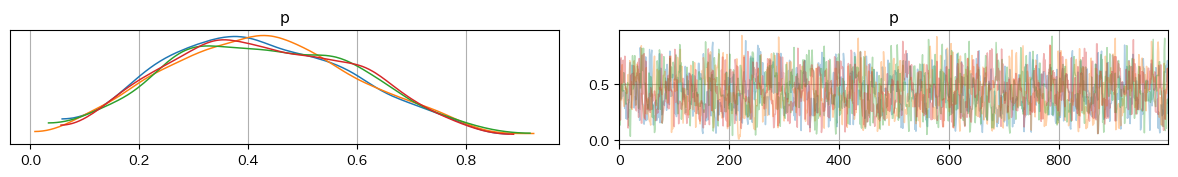

In [13]:
# 事後サンプルのトレースプロットによる収束診断
# ------------------------------------------------------------
# az.plot_trace は、ArviZ の「トレースプロット(trace plot)」を描画する関数。
# MCMC で得られたサンプル（今回は idata1_2 内の posterior サンプル）に対して、
#
#   - 上段: 各チェーンのサンプルの軌跡（時系列）
#   - 下段: そのサンプルのヒストグラムや KDE（事後分布の概形）
#
# をペアで表示してくれる。
#
# 理論的な役割は、「マルコフ連鎖が真の事後分布 p(p | X_obs) に十分混合・収束しているか」を
# 目視で診断することにある。
#
# 具体的には、各チェーンの時系列プロットを見て:
#
#   - サンプルが鎖ごとに異なるモードに張り付いていないか
#   - 時系列に強いトレンド（右肩上がり・下がり）が残っていないか
#   - ある程度の「ランダムウォークっぽさ（上下に揺れながらうろうろしている）」があるか
#
# などを確認する。
#
# 理論的には、十分長い MCMC 連鎖は「定常分布として事後分布を持つマルコフ連鎖」に
# 近づくことが期待される。トレースプロットは、その近似が実際にうまく機能しているかを
# 視覚的に確認するための基本ツールである。
axes = az.plot_trace(idata1_2, compact=False)

# レイアウト調整
# ------------------------------------------------------------
# plt.tight_layout() は、サブプロット間の余白を自動調整し、
# 軸ラベルやタイトルが重ならないように配置してくれる。
#
# トレースプロットでは
#
#   - 各チェーンの色分け
#   - 上段の時系列・下段の事後分布
#
# など、情報量の多い図が複数並ぶため、そのままだと軸ラベルや凡例が重なりやすい。
# tight_layout によって、それらを見やすい形に整えることで、
# 「どのチェーンがどのように動いているか」「事後分布の形がどうなっているか」
# を理論的・直感的の両面から読み取りやすくしている。
plt.tight_layout()

Text(0.5, 1.0, 'ベイズ推論結果\u3000初期版')

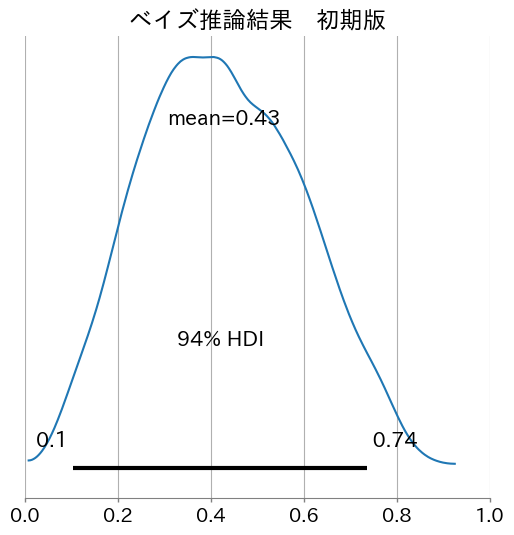

In [14]:
# 事後分布の可視化（ポスタリオルプロット）
# ------------------------------------------------------------
# plt.rcParams['figure.figsize'] = (6, 6) は、Matplotlib 全体のデフォルトの図サイズを
# 幅・高さともに 6 インチに設定している。
#
# 理論的な内容に直接は関係しないが、
# - トレースプロットやポスタリオルプロットを見やすい大きさにする
# - 複数の図を並べたときにスケールを揃える
# といった可視化上の実務的な工夫である。
plt.rcParams["figure.figsize"] = (6, 6)

# ArviZ による事後分布の要約可視化
# ------------------------------------------------------------
# az.plot_posterior(idata1_2) は、InferenceData (idata1_2) に格納された
# 「事後サンプル posterior」の分布を、1 次元の密度推定と区間（HDI など）を
# 組み合わせて可視化する関数である。
#
# 今回の model1 は
#
#   p ~ Uniform(0,1)
#   X_obs | p ~ Bernoulli(p)
#
# というベイズモデルなので、pm.sample によって得られた事後サンプルは
# 「成功確率 p に関する事後分布 p(p | X_obs)」の近似になっている。
#
# 理論的には、ベータ–ベルヌーイの共役性から
#
#   p(p | X_obs) = Beta(α_post, β_post)
#
# という形の分布になっており、
#
#   - α_post = α_prior + 成功回数
#   - β_post = β_prior + 失敗回数
#
# と更新される。ここで α_prior, β_prior は事前分布のパラメータ
# （Uniform(0,1) = Beta(1,1) の場合は α_prior=1, β_prior=1）である。
#
# az.plot_posterior は、この事後分布のサンプルに対して
#   - KDE（カーネル密度推定）による滑らかな密度曲線
#   - 中央値や平均のマーカー
#   - 最高密度区間 (HDI: Highest Density Interval)
# を一枚の図にまとめて描画することで、
#
#   「観測データを踏まえて、p がどのあたりにありそうか」
#   「どの範囲に高い確率質量が集中しているか」
#
# を直感的に理解できるようにしてくれる。
ax = az.plot_posterior(idata1_2)

# x 軸の範囲を [0,1] に固定
# ------------------------------------------------------------
# 成功確率 p は確率パラメータなので、理論的な定義域は
#
#   0 < p < 1
#
# である（事後分布の質量もこの区間に集中する）。
# plot_posterior の自動スケーリングに任せてもほぼこの範囲になるが、
# 明示的に 0〜1 に固定しておくことで、
#
#   - 「p が確率である」というスケール感が視覚的に保たれる
#   - 別の図（例えば事前分布や他のモデルの事後）との比較がしやすくなる
#
# といった利点がある。
ax.set_xlim(0, 1)

# タイトル設定
# ------------------------------------------------------------
# タイトル 'ベイズ推論結果　初期版' は、この図が
#
#   - モデル1 + 観測データ X_obs に基づく
#   - ベイズ推論（事後分布推定）の「初期バージョン」の結果
#
# であることを示している。
#
# 理論的には、この図で見ているものは
#
#   - 事前分布 p(p)（一様分布）
#   - 尤度 p(X_obs | p)
#
# をベイズの定理に従って統合した結果としての「事後分布 p(p | X_obs)」であり、
# それをサンプル + 可視化によって理解しようとしている、という位置づけになる。
#
# たとえば今後、
#   - 事前分布を変更した（例えば Beta(α,β) にした）バージョン
#   - 観測データの量を増減させたバージョン
# と比較する場合、「初期版」と明示しておくことで、
# ベイズ的な「事前・データ・事後の変化」のストーリーを整理しやすくなる。
plt.title("ベイズ推論結果　初期版")

In [15]:
# 事後サンプルの要約統計量の計算
# ------------------------------------------------------------
# az.summary は、ArviZ が提供する「MCMC サンプルの要約統計量」を計算する関数。
# ここでは idata1_2（pm.sample で得られた InferenceData）に対して適用し、
#
#   - 事後平均（mean）
#   - 事後標準偏差（sd）
#   - 各種パーセンタイル（hdi_xx / q_xx）
#   - R-hat（収束診断指標）
#   - 有効サンプルサイズ（ESS）
#
# などを表形式でまとめている。
#
# 理論的には、この表は
#
#   p(p \mid X_{\mathrm{obs}})
#
# という事後分布に関する「数値的な要約」を見ていることに相当する。
# 特にこのモデルでは、事前が一様分布（Beta(1,1)）で、尤度がベルヌーイ独立同分布なので、
# 解析的な事後分布は
#
#   p(p \mid X_{\mathrm{obs}}) = \mathrm{Beta}(\alpha_{\mathrm{post}}, \beta_{\mathrm{post}})
#
# というベータ分布になる（ベータ–ベルヌーイの共役性）。ここで
#
#   α_{\mathrm{post}} = α_{\mathrm{prior}} + s
#   β_{\mathrm{post}} = β_{\mathrm{prior}} + f
#
# であり、\(s\) は成功回数の合計、\(f\) は失敗回数である。
#
# したがって、理論的なベータ分布のモーメント
#
#   事後平均:
#   $$
#   \mathbb{E}[p \mid X_{\mathrm{obs}}]
#   = \frac{\alpha_{\mathrm{post}}}{\alpha_{\mathrm{post}} + \beta_{\mathrm{post}}}
#   $$
#
#   事後分散:
#   $$
#   \mathrm{Var}[p \mid X_{\mathrm{obs}}]
#   = \frac{\alpha_{\mathrm{post}} \beta_{\mathrm{post}}}
#           {(\alpha_{\mathrm{post}} + \beta_{\mathrm{post}})^2
#            (\alpha_{\mathrm{post}} + \beta_{\mathrm{post}} + 1)}
#   $$
#
# を、この summary1_2 に含まれる
#
#   - mean 列
#   - sd 列（標準偏差）
#
# と比較することで、
#
#   - MCMC による近似が理論分布とどの程度一致しているか
#   - サンプル数・チューニング設定が妥当か
#
# をチェックすることができる。
#
# また、R-hat が 1 に十分近く、有効サンプルサイズが十分大きいかどうかを確認することで、
# 「マルコフ連鎖が事後分布にきちんと収束しているか」という理論的な前提が
# 数値的にも満たされているかを診断できる。
summary1_2 = az.summary(idata1_2)

# 計算された要約統計量の表示
# ------------------------------------------------------------
# display(summary1_2) によって、Jupyter/Notebook 上に
# DataFrame 形式の要約統計量を表として表示する。
#
# ベイズ推論の観点では、この表を通じて
#
#   - p の「代表値」（事後平均・中央値）
#   - 不確実性の大きさ（事後標準偏差、HDI 幅）
#   - サンプラーの収束状況（R-hat、ESS）
#
# を一括で確認できるため、
#
#   1. モデル・事前の選択が妥当か？
#   2. サンプリング設定（chains, tune, draws）は十分か？
#   3. 理論的な事後分布（ここでは Beta 分布）と数値結果は整合しているか？
#
# といった点を検証するうえで、中心的な役割を果たすセルになっている。
display(summary1_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.427,0.174,0.104,0.737,0.004,0.002,1606.000,2514.000,1.000


In [16]:
# コンテキスト定義
# ------------------------------------------------------------
# PyMC における pm.Model() は「確率モデル全体（グラフィカルモデル）」のコンテナに相当する。
# model2 というインスタンスを作成し、with 文のブロック内で定義される確率変数を
# このモデルに紐づけていく。
#
# 理論的には、ここで構築するのは
#
#   1. パラメータ p（成功確率）に対する事前分布 p(p)
#   2. 観測データ X_obs に対する尤度 p(X_obs | p)
#
# からなるベイズモデルであり、ベイズの定理
#
#   p(p | X_obs) ∝ p(X_obs | p) p(p)
#
# に従って「事後分布 p(p | X_obs)」を求めるための枠組みに対応する。
model2 = pm.Model()

with model2:
    # 事前分布：pm.Uniform による一様事前
    # --------------------------------------------------------
    # p は「1 回の試行における成功確率」を表す連続パラメータで、理論的には
    #
    #   0 < p < 1
    #
    # の範囲を取る。
    # ここでは
    #
    #   p ~ Uniform(0, 1)
    #
    # と置くことで、「0〜1 のどの値も同じだけあり得る」という
    # 非情報的（フラット）な事前分布を仮定している。
    #
    # これはベータ分布で書けば
    #
    #   p ~ Beta(1, 1)
    #
    # と同値であり、後に二項分布の尤度と組み合わさることで
    # ベータ–二項モデル（Beta-Binomial）の共役構造を持つことになる。
    p = pm.Uniform("p", lower=0.0, upper=1.0)

    # 尤度（観測モデル）：pm.Binomial による二項分布
    # --------------------------------------------------------
    # X_obs は「n 回のベルヌーイ試行の中で観測された成功回数」を表す離散変数。
    # 理論的には
    #
    #   X_obs | p ~ Binomial(n, p)
    #
    # としてモデル化しており、このコードでは
    #
    #   n = 5（試行回数）
    #   観測値 X_obs = 2（成功回数）
    #
    # を与えている。
    #
    # 二項分布の確率質量関数 (PMF) は
    #
    #   P(X = k | p)
    #   = C(n, k) p^k (1-p)^{n-k}
    #
    # で与えられ、ここでは
    #
    #   P(X_obs = 2 | p) = C(5, 2) p^2 (1-p)^3
    #
    # が尤度関数として働く。
    #
    # ベイズ的には、
    #
    #   事前分布 : p(p) = Uniform(0,1) = Beta(1,1)
    #   尤度     : p(X_obs=2 | p) = C(5,2) p^2 (1-p)^3
    #
    # を組み合わせて、事後分布
    #
    #   p(p | X_obs = 2) ∝ p(X_obs = 2 | p) p(p)
    #
    # を定義していることになる。
    #
    # 共役性から、事後分布は解析的にベータ分布
    #
    #   p | X_obs = 2 ~ Beta(α_post, β_post)
    #
    # となる。ここで
    #
    #   α_prior = 1,  β_prior = 1  （一様事前 Beta(1,1)）
    #   成功回数 s = 2
    #   失敗回数 f = n - s = 3
    #
    # なので、
    #
    #   α_post = α_prior + s = 1 + 2 = 3
    #   β_post = β_prior + f = 1 + 3 = 4
    #
    # すなわち
    #
    #   p | X_obs = 2 ~ Beta(3, 4)
    #
    # という事後分布が理論的に導かれる。
    # PyMC では、このモデル定義に続けて pm.sample() を呼び出すことで、
    # この Beta(3,4) に相当する事後分布から MCMC サンプルを生成することになる。
    X_obs = pm.Binomial("X_obs", p=p, n=5, observed=2)

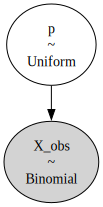

In [17]:
# モデル構造可視化
g = pm.model_to_graphviz(model2)
display(g)

In [18]:
with model2:
    idata2 = pm.sample(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


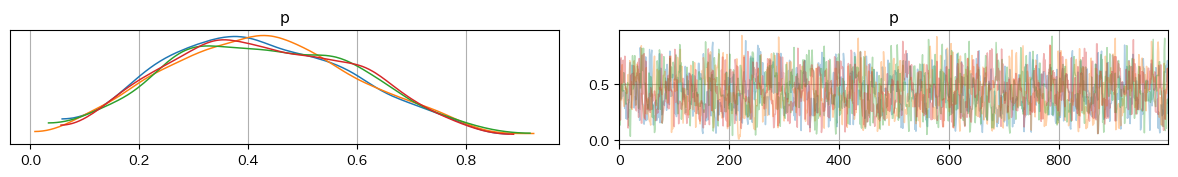

In [19]:
axes = az.plot_trace(idata2, compact=False)
plt.tight_layout()

Text(0.5, 1.0, 'ベイズ推論結果\u3000二項分布版')

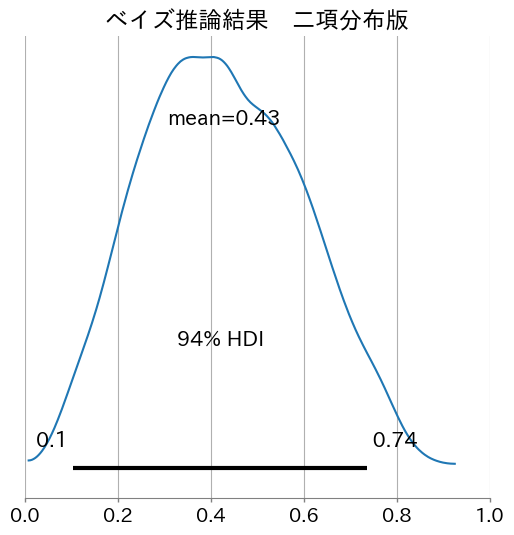

In [20]:
plt.rcParams["figure.figsize"] = (6, 6)
ax = az.plot_posterior(idata2)
ax.set_xlim(0, 1)
ax.set_title("ベイズ推論結果　二項分布版")

In [21]:
summary2 = az.summary(idata2)
display(summary2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.427,0.174,0.104,0.737,0.004,0.002,1606.000,2514.000,1.000
